<a href="https://colab.research.google.com/github/MauriAleman35/Modelos-ERP-Ecommerce/blob/main/ModeloRegresionLineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Carga de librerías
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt



Leer los Datos Excel

In [ ]:
# Si tus columnas de fecha se llaman "createdAT", parséalas así
ventas        = pd.read_csv("ventas.csv",        parse_dates=["createdAT"])
ventadetalles = pd.read_csv("ventadetalles.csv", parse_dates=["createdAT"])
productos     = pd.read_csv("productos.csv")
clientes      = pd.read_csv("clientes.csv")

# Verifica que todo cargó bien
print(ventas.shape, ventadetalles.shape, productos.shape, clientes.shape)
ventas.head()


(5007, 7) (11100, 11) (200, 13) (200, 10)


,_id,cliente,total,envio,estado,createdAT,__v
0,68045a2499e4b492e4ec985d,680450bf24880247e3b6d6fd,378,0,Procesado,2024-07-03 09:11:23,0
1,68045a2499e4b492e4ec985f,680450bf24880247e3b6d6fe,613,0,Confirmado,2024-07-03 08:55:32,0
2,68045a2599e4b492e4ec9863,680450bf24880247e3b6d6ff,111,0,Confirmado,2024-07-04 18:41:04,0
3,68045a2599e4b492e4ec9865,680450bf24880247e3b6d6fe,143,0,Confirmado,2024-07-05 19:21:56,0
4,68045a2699e4b492e4ec9867,680450bf24880247e3b6d6ff,66,0,Confirmado,2024-07-05 10:49:43,0


Merge con los excels

In [ ]:
# 2.1 añade el subtotal de cada línea (cantidad * precio_unitario)
ventadetalles["subtotal"] = ventadetalles["cantidad"] * ventadetalles["precio"]

# 2.2 agrupa por venta_id para obtener features por venta
resumen = ventadetalles.groupby("venta").agg(
    num_items     = ("cantidad", "sum"),         # total de ítems en el carrito
    ingreso_lineas= ("subtotal", "sum"),         # debería coincidir con ventas.total
    avg_precio    = ("precio", "mean"),          # precio promedio de ítem
    variedades    = ("variedad", "nunique"),     # cuántas variedades distintas compró
).reset_index()

df = resumen.merge(
    ventas,
    left_on="venta",
    right_on="_id",
    suffixes=("_det","_ven")
)
df.head()

,venta,num_items,ingreso_lineas,avg_precio,variedades,_id,cliente,total,envio,estado,createdAT,__v
0,68045a2499e4b492e4ec985d,3,378,126.000000,1,68045a2499e4b492e4ec985d,680450bf24880247e3b6d6fd,378,0,Procesado,2024-07-03 09:11:23,0
1,68045a2499e4b492e4ec985f,4,613,157.666667,3,68045a2499e4b492e4ec985f,680450bf24880247e3b6d6fe,613,0,Confirmado,2024-07-03 08:55:32,0
2,68045a2599e4b492e4ec9863,1,111,111.000000,1,68045a2599e4b492e4ec9863,680450bf24880247e3b6d6ff,111,0,Confirmado,2024-07-04 18:41:04,0
3,68045a2599e4b492e4ec9865,1,143,143.000000,1,68045a2599e4b492e4ec9865,680450bf24880247e3b6d6fe,143,0,Confirmado,2024-07-05 19:21:56,0
4,68045a2699e4b492e4ec9867,1,66,66.000000,1,68045a2699e4b492e4ec9867,680450bf24880247e3b6d6ff,66,0,Confirmado,2024-07-05 10:49:43,0


Extraer fechas y definir variables dependientes e independientes

In [ ]:
# 4.1 extraer variables temporales
df["dia_semana"] = df["createdAT"].dt.dayofweek    # 0=lunes … 6=domingo
df["mes"]        = df["createdAT"].dt.month
df["es_findes"]  = df["dia_semana"].isin([5,6]).astype(int)

# 4.2 usar los agregados del carrito
#    - num_items
#    - avg_precio
#    - variedades

# 4.3 por ejemplo incluir envío (si afecta al total)
df["envio"] = df["envio"]  # si quieres usarlo como predictor

# 4.4 definir X e y
X = df[[
    "dia_semana",
    "mes",
    "es_findes",
    "num_items",
    "avg_precio",
    "variedades",
    "envio"
]]
y = df["total"]
df.head()


,venta,num_items,ingreso_lineas,avg_precio,variedades,_id,cliente,total,envio,estado,createdAT,__v,dia_semana,mes,es_findes
0,68045a2499e4b492e4ec985d,3,378,126.000000,1,68045a2499e4b492e4ec985d,680450bf24880247e3b6d6fd,378,0,Procesado,2024-07-03 09:11:23,0,2,7,0
1,68045a2499e4b492e4ec985f,4,613,157.666667,3,68045a2499e4b492e4ec985f,680450bf24880247e3b6d6fe,613,0,Confirmado,2024-07-03 08:55:32,0,2,7,0
2,68045a2599e4b492e4ec9863,1,111,111.000000,1,68045a2599e4b492e4ec9863,680450bf24880247e3b6d6ff,111,0,Confirmado,2024-07-04 18:41:04,0,3,7,0
3,68045a2599e4b492e4ec9865,1,143,143.000000,1,68045a2599e4b492e4ec9865,680450bf24880247e3b6d6fe,143,0,Confirmado,2024-07-05 19:21:56,0,4,7,0
4,68045a2699e4b492e4ec9867,1,66,66.000000,1,68045a2699e4b492e4ec9867,680450bf24880247e3b6d6ff,66,0,Confirmado,2024-07-05 10:49:43,0,4,7,0


test/entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))


MAE: 34.487214758797414
R² : 0.9481653082805405


Visualizar


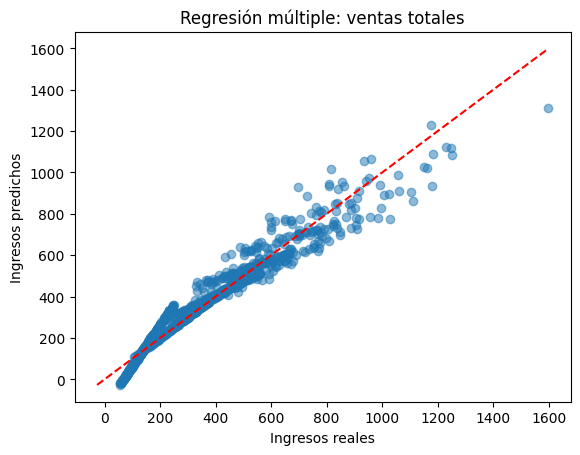

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "--r")
plt.xlabel("Ingresos reales")
plt.ylabel("Ingresos predichos")
plt.title("Regresión múltiple: ventas totales")
plt.show()
